<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/polyhedron-gdl/introduction-to-machine-learning-for-finance/blob/main/2022/1-notebooks/chapter-4-1.ipynb">
        <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Supervised Models: Linear and Logistic Regression

## Linear Regression

Despite its simplicity, a good understanding of linear regression is prerequisite for understanding how more advanced models work. Generally speaking, a linear model makes a prediction by simply computing a weighted
sum of the input features, plus a constant called the *bias* term (also called the *intercept*
term):

\begin{equation}
Y = a + b_1 X_1 + b_2 X_2 + \dots + b_m X_m + \epsilon
\end{equation}

where:

- $Y$ is the predicted value (the value of the target);
- $m$ is the number of features;
- $X_i$ is the $i^{th}$ feature value that are used to predict $Y$;
- $a$ and $b_j$ are the $j^{th}$ model parameters ($a$ being the bias term and $b_i$ the weights)
- $\epsilon$ is the predicton error.

As usual the parameters $a$ and $b_i$ are chosen to minimize the mean squared error over the training data set. 

This means that the task in linear regression is to find values for $a$ and $b_i$ that minimize

\begin{equation}
\frac{1}{n} \sum\limits_{i=1}^n \left( Y - a - b_1 X_{i1} - b_2 X_{i2} - \dots - b_m X_{im} \right)^2
\end{equation}

where $n$ is the size of the training set. 

Training a model means setting its parameters so that the model best fits the training set. For this purpose, we first need a measure of how well (or poorly) the model fits the training data. The most common performance measure of a regression model is the Root Mean Square Error (RMSE), therefore, to train a Linear Regression model, you need to find the value of $\theta$ that minimizes the RMSE. In practice, it is simpler to minimize the Mean Square Error (MSE) than the RMSE, and it leads to the same result.


## Example 1 - Predicting Iowa House Prices (from Kaggle)

In [14]:
# loading packages 

import os

import pandas as pd
import numpy as np

# plotting packages
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as clrs

# Kmeans algorithm from scikit-learn
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

#### The Problem

The objective is to predict the prices of house in Iowa from features. We have 800 observations in training set, 600 in validation set, and 508 in test set

#### Categorical Features (See Chapter 2-1)

Categorical features are features where there are a number of non-numerical alternatives. We can define a dummy variable for each alternative. The variable equals 1 if the alternative is true and zero otherwise. This is known as **one-hot encoding**.
But sometimes we do not have to do this because there is a natural ordering of variables. For example in this problem one of the categorical features is concerned with the basement quality as indicated by the ceiling height. The categories are:

- *Excellent (< 100 inches)*
- *Good (90-99 inches)*
- *Typical (80-89 inches)*
- *Fair (70-79 inches)*
- *Poor (< 70 inches)*
- *No Basement*

This is an example of a categorical variable where *there is* a natural ordering. We created a new variable that had a values of 5, 4, 3, 2, 1 and 0 for the above six categories respectively.

The other categorical features specifies the location of the house as in one of 25 neighborhoods. We introduce 25 dummy variables with a one-hot encoding. The dummy variable equals one for an observation if the neighborhood is that in which the house is located and zero otherwise.

#### Loading data (J. C. Hull, 2019, Chapter 3)

To illustrate the regression techniques discussed in this chapter we will use a total of 48 feature. 21 are numerical and two are categorical and to this we had, as discussed above, 25 categorical variables for the neighborhoods. 

In [15]:
#
# upload file 'Houseprice_data_scaled.csv'
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [16]:
# Both features and target have already been scaled: mean = 0; SD = 1
data = pd.read_csv(path + 'Houseprice_data_scaled.csv') 
data.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,...,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual,Sale Price
0,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,1.203988,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.358489
1,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,-0.789421,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,10.905682,0.584308,0.008849
2,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,1.231999,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.552733
3,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,0.975236,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,-0.577852,-0.528560
4,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,1.668495,...,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308,0.895898


First of all check how many records we have

In [17]:
print("Number of available data = "  + str(len(data.index)))

Number of available data = 2908


Before starting we emphasize the need to divide all available data into three parts: a **training set**, a **validation set** and a **test set**. The training set is used to determine parameters for trial models. The validation set is used to determine the extent to which the models created from the training set generalize to new data. Finally, the test set is used as a final estimate of the accuracy of the chosen model. 

We had 2908 observations. We split this as follows: 1800 in the training set, 600 in the validation set and 508 in the test set.

In [18]:
# First 1800 data items are training set; the next 600 are the validation set
train = data.iloc[:1800] 
val = data.iloc[1800:2400]

We now procede to create **labels** and **features**. As we have already said, the labels are the values of the target that is to be predicted, in this case the 'Sale Price', and we indicate that whit 'y':

In [19]:
y_train, y_val = train[['Sale Price']], val[['Sale Price']] 

The features and dummy variables were scaled using the Z-score method. Also the target values (i.e. the house prices) have been scaled with the Z-score method. The features are the variables from which the predictions are to be made and, in this case, can be obtained simply dropping the column 'Sale Price' from our dataset:

In [20]:
X_train, X_val = train.drop('Sale Price', axis=1), val.drop('Sale Price', axis=1)

In [21]:
X_train.columns

Index(['LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr',
       'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV',
       'Mitchel', 'Names', 'NoRidge', 'NPkVill', 'NriddgHt', 'NWAmes',
       'OLDTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber',
       'Veenker', 'Bsmt Qual'],
      dtype='object')

#### Linear Regression with sklearn

In [22]:
# Importing models
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

In [23]:
lr = LinearRegression()
lr.fit(X_train,y_train)

LinearRegression()

In [24]:
lr.intercept_

array([-67.80317104])

In [25]:
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
)
coeffs

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
0,intercept,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,...,NWAmes,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual
1,-67.803171,0.07895,0.214535,0.096406,0.160694,0.025279,0.091253,-0.033319,0.138197,0.152663,...,-169002100997.478638,-204553438461.897186,-103484575079.148849,-165439300001.57016,-158017198153.675934,-193160539336.459869,-97119995960.772537,-115086723047.832458,-70123747244.156418,0.011422


In [26]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-67.803171
LotArea,0.07895
OverallQual,0.214535
OverallCond,0.096406
YearBuilt,0.160694
YearRemodAdd,0.025279
BsmtFinSF1,0.091253
BsmtUnfSF,-0.033319
TotalBsmtSF,0.138197


In [27]:
len(coeffs.index)

48

In [28]:
pred_t=lr.predict(X_train)
mse(y_train,pred_t)

0.11401498824553064

In [29]:
pred_v=lr.predict(X_val)
mse(y_val,pred_v)

0.11700244623108394

For the data we are considering it turns out that this regression model generalizes well. The mean squared error for the validation set was only a little higher than that for the training set. However linear regression with no regularization leads to some strange results because of the correlation between features. For example it makes no sense that the weights for number of full bathrooms and number of bedrooms are negative!

In [30]:
x1 = X_train['GrLivArea']
x2 = X_train['BedroomAbvGr']
x1.corr(x2)

0.5347396038733943

###### Ridge Regression

In [31]:
# Importing Ridge
from sklearn.linear_model import Ridge

We try using Ridge regression with different values of the hyperparameter $\lambda$. The following code shows the effect of this parameter on the prediction error. 

In [32]:
# The alpha used by Python's ridge should be the lambda in Hull's book times the number of observations
alphas=[0.01*1800, 0.02*1800, 0.03*1800, 0.04*1800, 0.05*1800, 0.075*1800,0.1*1800,0.2*1800, 0.4*1800]
mses=[]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    pred=ridge.predict(X_val)
    mses.append(mse(y_val,pred))
    print(mse(y_val,pred))

0.11703284346091355
0.11710797319753011
0.11723952924901142
0.11741457158889522
0.11762384068711472
0.11825709631198032
0.11900057469147939
0.12254649996292957
0.13073599680747142


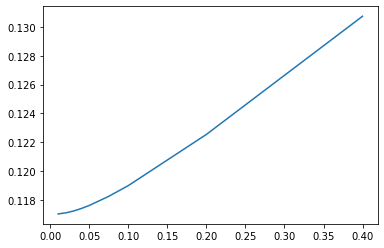

In [33]:
plt.plot(np.array(alphas)/1800, mses)

As expected the prediction error increases as $\lambda$ increases. Values of $\lambda$ in the range $0$ to $0.1$ might be reasonably be considered because prediction errors increases only slightly when $\lambda$ is in this range. However it turns out that the improvement in the model is quite small for these values of $\lambda$.

###### Lasso

In [34]:
# Import Lasso
from sklearn.linear_model import Lasso

In [35]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.04)
lasso.fit(X_train, y_train)

Lasso(alpha=0.04)

In [36]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.0
LotArea,0.051706
OverallQual,0.288466
OverallCond,0.005268
YearBuilt,0.060314
YearRemodAdd,0.066641
BsmtFinSF1,0.118631
BsmtUnfSF,-0.0
TotalBsmtSF,0.100542


###### Lasso with different levels of alpha and its mse

In [37]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.06/2, 0.08/2, 0.09/2, 0.1/2]
mses=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_val)
    mses.append(mse(y_val,pred))
    print("lambda = " + '{:<05}'.format(alpha) + " - mse = " + str(round(mse(y_val, pred),6)))

lambda = 0.005 - mse = 0.116548
lambda = 0.010 - mse = 0.116827
lambda = 0.015 - mse = 0.118033
lambda = 0.020 - mse = 0.120128
lambda = 0.025 - mse = 0.123015
lambda = 0.030 - mse = 0.126462
lambda = 0.040 - mse = 0.133492
lambda = 0.045 - mse = 0.137016
lambda = 0.050 - mse = 0.140172


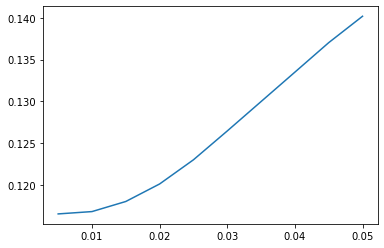

In [38]:
plt.plot(alphas, mses)

Lasso regression leads to more interesting results. In the plot above you can see how the error in the validation set changes as tha value of the lasso $\lambda$ increases. For small values of $\lambda$ the error is actually less than when $\lambda = 0$ but as $\lambda$ increases beyond about $0.03$ the error starts to increase. A value of $\lambda = 0.04$ could be chosen.   

## What is Logistic Regression

### Classification Problem

As we know there are two types of supervised learning models: those that are used to **predict** a numerical variable and those that are used for **classification**. Up to now we have considered the problem of predicting a numerical variable, we now move on to the classification problem. In particular we focus on the so called Binomial Logistic Regression, where the response variable has two values 0 and 1 or pass and fail or true and false. Multinomial Logistic Regression deals with situations where the response variable can have three or more possible values. 

### Why Logistic, not Linear?

With binary classification, let $x$ be some feature and $y$ be the output which can be either 0 or 1.
The probability that the output is 1 given its input can be represented as:

$$P(y=1 \vert x) $$

If we predict the probability via linear regression, we can state it as:

$$P(y=1 \vert x) = \beta_0 + \beta_1 X$$

Linear regression model can generate the predicted probability as any number ranging from negative to positive infinity, whereas probability of an outcome can only lie between 0< P(x)<1.

![chapter-4-1_pic_0.png](./pic/chapter-4-1_pic_0.png)

To avoid this problem, log-odds function or logit function is used.

### Logit Function

Logistic regression can be expressed as:

\begin{equation}
\log \left( \frac{p(y=1\vert x)}{1-p(y=1\vert x)}\right) = \beta_0 + \beta_1 X
\end{equation}

where, the left hand side is called the *logit* or *log-odds* function, and $p/(1-p)$ is called *odds*. The odds signifies the ratio of probability of success to probability of failure. Therefore, in Logistic Regression, linear combination of inputs are mapped to the log(odds) - the output being equal to 1. If we take an inverse of the above function, we get:

\begin{equation}
Q=p(y=1 \vert x) = \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}} = \frac{1}{1+e^{-(\beta_0 + \beta_1 X)}} =
\frac{1}{1+e^{-Y}}
\end{equation}

where $Y= \beta_0 + \beta_1 X$. 

This is known as the **Sigmoid Function** and it gives an S-shaped curve. It always gives a value of probability ranging from $0<p<1$. Now, let's simply plot the sigmoid function for some values in the range –7 to 7 to
see how it looks:

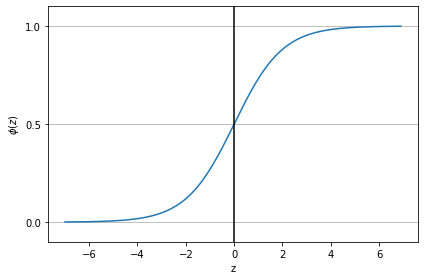

In [39]:
import matplotlib.pyplot as plt
import numpy as np

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color='k')
plt.ylim(-0.1, 1.1)
plt.xlabel('z')
plt.ylabel('$\phi (z)$')
# y axis ticks and gridline
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

The output of the sigmoid function is then interpreted as the probability of a particular example belonging to class 1, $\Phi(z) = P(y=1 \vert \mathbf{x}; \mathbf{w})$, given its features, $x$, parameterized by the weights, $w$. The predicted probability can then simply be converted into a binary outcome via a threshold function:

$$\hat y = \begin{cases}
              &1 \quad \text{if } \phi(z) \ge 0.5 \\ & 0 \quad \text{otherwise}
              \end{cases}$$

If we look at the preceding plot of the sigmoid function, this is equivalent to the

following:

$$\hat y = \begin{cases}
              &1 \quad \text{if } z \ge 0 \\ & 0 \quad \text{otherwise}
              \end{cases}$$


### Estimation of Regression Coefficients

Unlike linear regression model, that uses Ordinary Least Square for parameter estimation, we use Maximum Likelihood Estimation.
There can be infinite sets of regression coefficients. The maximum likelihood estimate is that set of regression coefficients for which the probability of getting the data we have observed is maximum. In this case we can write simply:

\begin{equation}
{\cal{L}} = \prod\limits_{i=1}^n  Q(\mathbf{\beta}^T \mathbf{x})^{y(i)} \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right]^{1-y(i)} \Rightarrow \log{\cal{L}} = 
\sum\limits_{i=1}^n
\left\{
{y(i)} \cdot \ln Q(\mathbf{\beta}^T \mathbf{x}) 
+ (1-y(i)) \cdot \ln \left[ 1 - Q(\mathbf{\beta}^T \mathbf{x})\right] 
\right\}
\end{equation}

Now since in the binomial case $y_i = 1 \,or\, 0$, we can write

\begin{equation}L=\sum\limits_\text{POS OUT} \, \ln(Q) + \sum\limits_\text{NEG OUT} \, \ln(1-Q) \end{equation}

The first summation is over all the observations which led to positive outcomes and the second summation is over all observations which let to negative outcomes. This function cannot be maximized analytically and gradient ascent (analogous to gradient descent) methods must be used.

Let's write a short code snippet to create a plot that illustrates the cost of classifying
a single training example for different values of $\phi(z)$ :

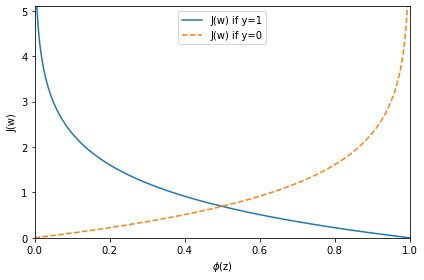

In [40]:
def cost_1(z):
    return - np.log(sigmoid(z))

def cost_0(z):
    return - np.log(1 - sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
c1 = [cost_1(x) for x in z]
plt.plot(phi_z, c1, label='J(w) if y=1')
c0 = [cost_0(x) for x in z]
plt.plot(phi_z, c0, linestyle='--', label='J(w) if y=0')
plt.ylim(0.0, 5.1)
plt.xlim([0, 1])
plt.xlabel('$\phi$(z)')
plt.ylabel('J(w)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

We can see that the cost approaches 0 (continuous line) if we correctly predict that
an example belongs to class 1. Similarly, we can see on the y-axis that the cost also
approaches 0 if we correctly predict y = 0 (dashed line). However, if the prediction
is wrong, the cost goes toward infinity. The main point is that we penalize wrong
predictions with an increasingly larger cost.

## Performance of Logistic Regression model

To evaluate the performance of a logistic regression model, Deviance is used in lieu of sum of squares calculations.

- Null Deviance indicates the response predicted by a model with nothing but an intercept.
- Model deviance indicates the response predicted by a model on adding independent variables. If the model deviance is significantly smaller than the null deviance, one can conclude that the parameter or set of parameters significantly improved model fit.
- Another way to find the accuracy of model is by using Confusion Matrix.

![image.png](./pic/chapter-4-1_pic_2.png)

## Example 2 - Application to Credit Decision 

In this section we consider a subset of the data provided by the company Lending Club on its credit decision. For a complete description see the textbook of J. C. Hull chapter 3, pag. 73.

LENDING CLUB BACKGROUND
Lending Club is a peer-to-peer (P2P) lending platform, where borrowers submit their loan applications and individual lenders select the applications that they want to fund. Borrowers receive the full amount of the issued loan minus the origination fee, which is paid to the company. Investors purchase notes backed by the personal loans and pay Lending Club a service fee.

P2P lending brings down the cost of personal loans compared to traditional financing by connecting the borrowers and investors directly. However, there is always a risk of investing in a bad loan. In fact, the default rate for P2P loans are much higher than that of traditional loans. Therefore, the lending industry is highly interested in providing the investors with comprehensive risk assessment of the loan applications. The company shares data about all loan applications made through its platform. 

In [41]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import openpyxl
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, average_precision_score

In [42]:
#
# load file lendingclub_traindata.xlsx
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()
    path = ''
else:
    path = './data/'

In [43]:
#
# load file lendingclub_testdata.xlsx
#
if 'google.colab' in str(get_ipython()):
    from google.colab import files
    uploaded = files.upload()

In [44]:
train = pd.read_excel(path + 'lendingclub_traindata.xlsx', engine='openpyxl')
test = pd.read_excel(path + 'lendingclub_testdata.xlsx', engine='openpyxl')

In [45]:
# 1 = good, 0 = default

# give column names
cols = ['home_ownership', 'income', 'dti', 'fico_low', 'loan_status']
train.columns = test.columns = cols

print(train.head())
print("--------------------------------")
print(test.head())

   home_ownership  income    dti  fico_low  loan_status
0               1  44.304  18.47       690            0
1               0  38.500  33.73       660            0
2               1  54.000  19.00       660            0
3               1  60.000  33.98       695            0
4               0  39.354  10.85       685            0
--------------------------------
   home_ownership  income    dti  fico_low  loan_status
0               1   127.0  10.94       675            0
1               1   197.0  15.64       710            0
2               1    25.5  28.75       670            0
3               1    80.0  20.16       660            0
4               0    57.0  30.60       675            0


For the purposes of this exercise, the dataset has already been split into train and test set. There are 8695 instances of training set and 5916 instances of test set with with four features and one target. The four features are home_ownership, income, dti and fico_low and the target is loan status that includes either fully paid or defaulted loans only. 

In [46]:
# remove target column to create feature only dataset
X_train = train.drop('loan_status', 1)
X_test = test.drop('loan_status', 1)

# store target column
y_train = train['loan_status']
y_test = test['loan_status']

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.columns

(8695, 4) (8695,) (5916, 4) (5916,)


Index(['home_ownership', 'income', 'dti', 'fico_low'], dtype='object')

By default the mode() method return the highest frequency value in a Series

In [47]:
y_train.mode()[0]

1

In [48]:
majority_class = y_train.mode()[0]        # predict fully paid only
prediction = np.full(shape=y_train.shape, fill_value=majority_class)
accuracy_score(y_train, prediction)

0.8276020701552617

In [49]:
freq = y_train.value_counts()           # count frequency of different classes in loan status
freq/sum(freq)*100                      # get percentage of above

1    82.760207
0    17.239793
Name: loan_status, dtype: float64

In [50]:
# create an instance of logistic regression
lgstc_reg =  LogisticRegression(penalty="none", solver='newton-cg')     
# fit training data on logistic regression 
lgstc_reg.fit(X_train, y_train)                                                             
# get the coefficients of each features
print(lgstc_reg.intercept_, lgstc_reg.coef_)                                                

[-6.56522523] [[ 0.139496    0.00410667 -0.00112302  0.01125209]]


<br>
The bias is estimated as -6.56517476. The coefficient of the logistic regression are 0.13949599 for home_ownership, 0.0041 0667 for income, -0.00112303 for dti and 0.01125202 for fico_low. These are the weights (parameters) that maximizes the likelihood of producing our given data and hence gives us the least error in predicting our response variable.

The question of how to evaluate the model is of the utmost importance. This is where we will test the model's performance on an unseen test set and check the results of our chosen measure of success. This step is meant to be representative of how the model might perform in the real world.

In [51]:
# predict default loans based on test data set
y_pred = lgstc_reg.predict(X_test)                           

<br> 
An analyst must decide on a criterion for predicting whether loan will be good or default. This involves specifying a threshold. By default this threshold is set to 0.5, i.e., loans are separated into good and bad categories according to whether the probability of no default is greater or less than 0.5. However this does not work well for an imbalanced data set such as this. It would predict that all loans are good! We will look at the results for few other thresholds. 



From the confusion matrix, we can derive some important metrics

> **Accuracy** is one metric for evaluating classification models. Informally, accuracy is the fraction of predictions our > model got right. Formally, accuracy has the following definition:
>
>$$\text{accuracy} = \frac{\text{number of correct predictions}}{\text{total number of predictions}}$$
>
> For binary classification, accuracy can also be calculated in terms of positives and negatives as follows:
>
>$$\text{accuracy} = \frac{TP + TN}{TP + TN + FP + FN}$$
>
> Where TP = True Positives, TN = True Negatives, FP = False Positives, and FN = False Negatives.

> **Precision** attempts to answer the following question: What proportion of positive identifications was actually > correct? Precision is defined as follows:
>
>$$\text{precision} = \frac{TP}{TP+FP}$$

> **Recall** attempts to answer the following question: What proportion of actual positives was identified correctly?
> Mathematically, recall is defined as follows:
>
> $$\text{recall} = \frac{TP}{TP+FN}$$

In [52]:
THRESHOLD = [.75, .80, .85]
# df to store results
results = pd.DataFrame(columns=["THRESHOLD", "accuracy", "recall", "tnr", "fpr", "precision", "f1_score"]) 
# threshold column
results['THRESHOLD'] = THRESHOLD                                                                           
             
j = 0                                                                                                      
# iterate over each threshold    
for i in THRESHOLD:     
    # fit data to model
    lgstc_reg.fit(X_train, y_train)
    # if prob > threshold, predict 1
    preds = np.where(lgstc_reg.predict_proba(X_test)[:,1] > i, 1, 0)                                       
    # confusion matrix (in percentage)
    cm = (confusion_matrix(y_test, preds,labels=[1, 0], sample_weight=None) / 5916 )*100                   
    
    print('Confusion matrix for threshold =',i)
    print(cm)
    print(' ')      
    
    TP = cm[0][0]   # True Positives
    FN = cm[0][1]   # False Positives
    FP = cm[1][0]   # True Negatives
    TN = cm[1][1]   # False Negatives
        
    results.iloc[j,1] = accuracy_score(y_test, preds) 
    results.iloc[j,2] = recall_score(y_test, preds)
    results.iloc[j,3] = TN/(FP+TN)  # True negative rate
    results.iloc[j,4] = FP/(FP+TN)  # False positive rate
    results.iloc[j,5] = precision_score(y_test, preds)
    results.iloc[j,6] = f1_score(y_test, preds)
   
    j += 1

print('ALL METRICS')
print( results.T)
   

Confusion matrix for threshold = 0.75
[[77.5862069   4.5300879 ]
 [16.26098715  1.62271805]]
 
Confusion matrix for threshold = 0.8
[[55.34144692 26.77484787]
 [ 9.75321163  8.13049358]]
 
Confusion matrix for threshold = 0.85
[[28.65111562 53.46517918]
 [ 3.73563218 14.14807302]]
 
ALL METRICS
                  0         1         2
THRESHOLD      0.75       0.8      0.85
accuracy   0.792089  0.634719  0.427992
recall     0.944833   0.67394  0.348909
tnr        0.090737  0.454631  0.791115
fpr        0.909263  0.545369  0.208885
precision  0.826729  0.850169  0.884656
f1_score   0.881844  0.751866  0.500443


<br>
We note here from the confusion matrix at threshold 0.75 that while the model is good at identifying good loans, however it isn't good at identifying the bad loans at all.

We also note that increasing the threshold results in decrease in overall accuracy. But the percentage of default loans identified as default is higher with increasing threshold. We know by now that maximizing the accuracy does not necessarily create the best model. Thus, lets look at some other metrics.

In [53]:
print( 'ALL METRICS' )
print( results.T )

ALL METRICS
                  0         1         2
THRESHOLD      0.75       0.8      0.85
accuracy   0.792089  0.634719  0.427992
recall     0.944833   0.67394  0.348909
tnr        0.090737  0.454631  0.791115
fpr        0.909263  0.545369  0.208885
precision  0.826729  0.850169  0.884656
f1_score   0.881844  0.751866  0.500443


### What is the AUC - ROC Curve?
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1. By analogy, the Higher the AUC, the better the model is at distinguishing between patients with the disease and no disease. The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

![caption](./pic/chapter-4-1_pic_8.png)

In the context of classification tasks, some sklearn estimators also implement the predict_proba method that returns the class probabilities for each data point. The method accepts a single argument that corresponds to the data over which the probabilities will be computed and returns an array of lists containing the class probabilities for the input data points.

In [59]:
lr_prob=lgstc_reg.predict_proba(X_test)
lr_prob=lr_prob[:, 1]

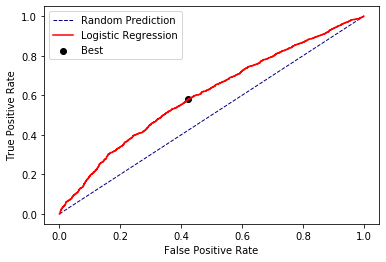

AUC Score      :  0.6019668412790937
Best Threshold :  0.8147754801447648


In [85]:
lr_auc=roc_auc_score(y_test, lr_prob)

lr_fpr,lr_tpr, thresholds =roc_curve(y_test,lr_prob)

# calculate the g-mean for each threshold
gmeans = np.sqrt(lr_tpr * (1-lr_fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)

plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--", label='Random Prediction')
plt.plot(lr_fpr,lr_tpr , color="red" , label='Logistic Regression')
plt.scatter(lr_fpr[ix], lr_tpr[ix], marker='o', color='black', label='Best')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print("AUC Score      : ", lr_auc)
print("Best Threshold : ", thresholds[ix])


## References

John C. Hull, **Machine Learning in Business: An Introduction to the World of Data Science**, Amazon, 2019.

Paul Wilmott, **Machine Learning: An Applied Mathematics Introduction**, Panda Ohana Publishing, 2019.